<a href="https://colab.research.google.com/github/miracle65536/XAIentists/blob/ModelBuildingPratibha/Copy_of_ModelBuilding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

<div class="markdown-google-sans">
  <h2>Explore the Gemini API</h2>
  <p>The Gemini API gives you access to Gemini models created by Google DeepMind. Gemini models are built from the ground up to be multimodal, so you can reason seamlessly across text, images, code, and audio.
  </p>
  <strong>How to get started</strong>
    <ol>
      <li>Go to <a href="https://aistudio.google.com/">Google AI Studio</a> and log in with your Google account.</li>
      <li><a href="https://aistudio.google.com/app/apikey">Create an API key</a>.</li>
      <li>Use a quickstart for <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Prompting.ipynb">Python</a>, or call the REST API using <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb">curl</a>.</li>
      </ol>
  <strong>Explore use cases</strong>
    <ul>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Market_a_Jet_Backpack.ipynb">Create a marketing campaign</a></li>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Audio.ipynb">Analyze audio recordings</a></li>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/System_instructions.ipynb">Use System instructions in chat</a></li>
    </ul>
  <p>To learn more, check out the <a href="https://github.com/google-gemini/cookbook">Gemini cookbook</a> or visit the <a href="https://ai.google.dev/docs/">Gemini API documentation</a>.
  </p>
</div>


In [2]:
import pandas as pd

In [5]:
df=pd.read_csv('../Data/Processed/compas-scores-two-years-processed.csv')
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,is_recid,r_charge_degree,r_days_from_arrest,r_charge_desc,is_violent_recid,vr_charge_degree,vr_charge_desc,c_length_of_stay,r_length_of_stay,custody_length_of_stay,two_year_recid
0,Male,Greater than 45,Other,0,0,0,0,F,0.003327,0,NaN,NaN,NaN,0,NaN,NaN,0.98,NaN,7.0,0
1,Male,25 - 45,African-American,0,0,0,0,F,0.006376,1,(F3),0.0,0.005186,1,(F3),0.046398,10.08,8.0,10.0,1
2,Male,Less than 25,African-American,0,0,1,4,F,0.065706,1,(M1),0.0,0.006626,0,NaN,NaN,1.09,0.0,0.0,1
3,Male,Less than 25,African-American,0,1,0,1,F,0.010535,0,NaN,NaN,NaN,0,NaN,NaN,1.28,NaN,2.0,0
4,Male,25 - 45,Other,0,0,0,2,F,0.158442,0,NaN,NaN,NaN,0,NaN,NaN,1.28,NaN,2.0,0


In [8]:
df.shape

(7214, 20)

In [16]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [9]:
df.dtypes

sex                        object
age_cat                    object
race                       object
juv_fel_count               int64
juv_misd_count              int64
juv_other_count             int64
priors_count                int64
c_charge_degree            object
c_charge_desc             float64
is_recid                    int64
r_charge_degree            object
r_days_from_arrest        float64
r_charge_desc             float64
is_violent_recid            int64
vr_charge_degree           object
vr_charge_desc            float64
c_length_of_stay          float64
r_length_of_stay          float64
custody_length_of_stay    float64
two_year_recid              int64
dtype: object

In [10]:
# Apply one-hot encoding to categorical columns, excluding columns with embeddings
categorical_cols = ['sex', 'race', 'age_cat', 'c_charge_degree', 'r_charge_degree', 'vr_charge_degree']
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# Drop columns with object dtype that are causing issues
object_cols = df_encoded.select_dtypes(include=['object']).columns
df_encoded = df_encoded.drop(columns=object_cols)

In [12]:
print(df_encoded.shape)
df_encoded.head()

(7214, 46)


,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_desc,is_recid,r_days_from_arrest,r_charge_desc,is_violent_recid,vr_charge_desc,...,r_charge_degree_(MO3),vr_charge_degree_(F1),vr_charge_degree_(F2),vr_charge_degree_(F3),vr_charge_degree_(F5),vr_charge_degree_(F6),vr_charge_degree_(F7),vr_charge_degree_(M1),vr_charge_degree_(M2),vr_charge_degree_(MO3)
0,0,0,0,0,0.003327,0,NaN,NaN,0,NaN,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,0,0.006376,1,0.0,0.005186,1,0.046398,...,False,False,False,True,False,False,False,False,False,False
2,0,0,1,4,0.065706,1,0.0,0.006626,0,NaN,...,False,False,False,False,False,False,False,False,False,False
3,0,1,0,1,0.010535,0,NaN,NaN,0,NaN,...,False,False,False,False,False,False,False,False,False,False
4,0,0,0,2,0.158442,0,NaN,NaN,0,NaN,...,False,False,False,False,False,False,False,False,False,False


In [13]:
y = df_encoded['two_year_recid']         # target variable
X = df_encoded.drop(columns='two_year_recid')    # features

In [17]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [18]:
# Initialize XGBClassifier
xgb = XGBClassifier(objective= 'binary:logistic', random_state = 0)

# Defining classifier parameters
cv_params = {'max_depth': [4,5,6],
              'min_child_weight' : [2,3,4],
              'learning_rate' : [0.1,0.2, 0.3],
              'n_estimators' : [50, 100]
            }

scoring =  {'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1'}

# Performing GridSearch
xgb_cv = GridSearchCV (xgb, cv_params, scoring = scoring, cv = 5, refit = 'f1')

# Record start time
start_time = time.time()

#Train the model
xgb_cv.fit(X_train, y_train)

# Record end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")

Training time: 39.63 seconds


In [19]:
print("Best parameters:", xgb_cv.best_params_)
print("Best F1 score:", xgb_cv.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 50}
Best F1 score: 0.9654730404780782


In [23]:
# Make predictions on the test set
y_pred = xgb_cv.best_estimator_.predict(X_test)

In [24]:
# get the accuracy of the trained classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.97


In [21]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1132   57]
 [   0  976]]


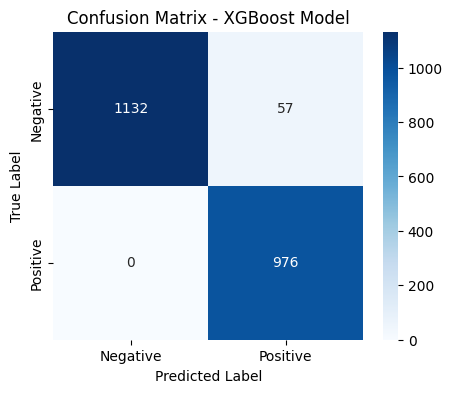

In [22]:
# Plot the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost Model")
plt.show()

In [27]:
# Now that we finished training the model, let's save the trained model to a file so that we can use it in the explanation notebook; this will keep things modular and organized.
import joblib

# Save the model to a file
joblib.dump(xgb_cv.best_estimator_, '../Trained Models/xgboost_model.pkl')



['../Trained Models/xgboost_model.pkl']